In [30]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
# Essential imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Additional imports
import glob
import random
import pandas as pd
import cv2
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import functional as F

# Autoreload and matplotlib setting
%load_ext autoreload
%autoreload 2
%matplotlib inline



In [31]:
import os
import pandas as pd

def get_profile_path(folder_path):
    data = []

    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for subcategory in os.listdir(category_path):
                subcategory_path = os.path.join(category_path, subcategory)
                if os.path.isdir(subcategory_path):
                    for image_file in os.listdir(subcategory_path):
                        if image_file.endswith('.png'):
                            pet_id = image_file.split('.')[0]
                            image_path = os.path.join(subcategory_path, image_file)
                            data.append({
                                'DysID': dys_id,
                                'path': image_path,
                                'category': category,
                                'subcategory': subcategory
                            })
            
    return pd.DataFrame(data)

# Replace 'E:/Gambo/train' with the path to your 'train' folder
train = get_profile_path('E:/Gambo/Train')


In [32]:
import os
import cv2
import torch
import numpy as np
from torchvision.transforms import functional as F

def resize_to_square(image, size):
    h, w, d = image.shape
    ratio = size / max(h, w)
    resized_image = cv2.resize(image, (int(w * ratio), int(h * ratio)), cv2.INTER_AREA)
    return resized_image

def pad(image, min_height, min_width):
    h, w, d = image.shape
    if h < min_height:
        h_pad_top = int((min_height - h) / 2.0)
        h_pad_bottom = min_height - h - h_pad_top
    else:
        h_pad_top = 0
        h_pad_bottom = 0

    if w < min_width:
        w_pad_left = int((min_width - w) / 2.0)
        w_pad_right = min_width - w - w_pad_left
    else:
        w_pad_left = 0
        w_pad_right = 0

    return cv2.copyMakeBorder(image, h_pad_top, h_pad_bottom, w_pad_left, w_pad_right, cv2.BORDER_CONSTANT, value=(0, 0, 0))

class HandwritingDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_path, size=28):
        self.data_path = data_path
        self.size = size
        self.image_paths = []
        self.labels = []
        self.load_data()

    def load_data(self):
        categories = ['Corrected', 'Normal', 'REVERSAL']
        for category in categories:
            category_path = os.path.join(self.data_path, category)
            if not os.path.isdir(category_path):
                continue

            for file_name in os.listdir(category_path):
                image_path = os.path.join(category_path, file_name)
                if image_path.endswith('.png'):
                    self.image_paths.append(image_path)
                    # Assuming dyslexic is labeled as 1 and non-dyslexic as 0
                    self.labels.append(1 if 'Corrected' in category else 0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = resize_to_square(image, self.size)
        image = pad(image, self.size, self.size)
        tensor = torch.from_numpy(np.moveaxis(image / 255., -1, 0).astype(np.float32))
        tensor = F.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            
        return tensor, label

# Usage example:
data_path = 'E:/Gambo/Train'
handwriting_dataset = HandwritingDataset(data_path)


In [33]:
import random

# Set the random seed
random.seed(70)

# Generate some random numbers
print(random.random())  # Will always print the same number when the code is run with the seed set to 70


0.909769237923872


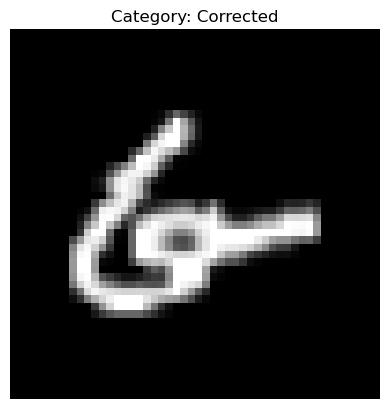

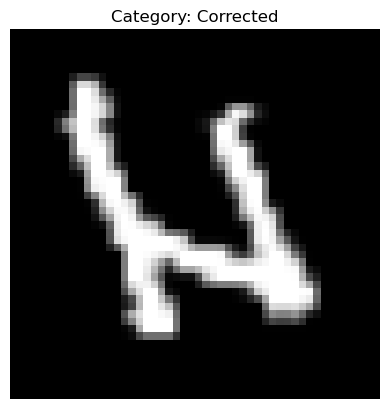

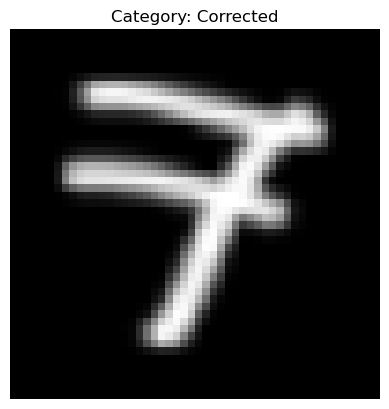

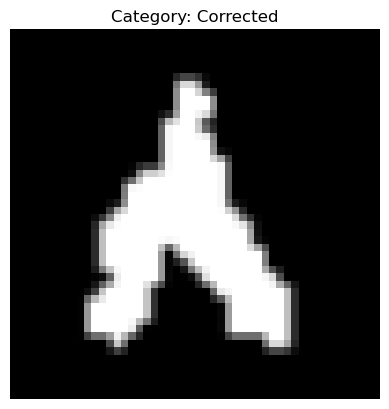

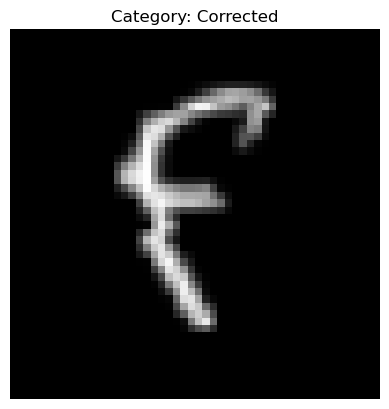

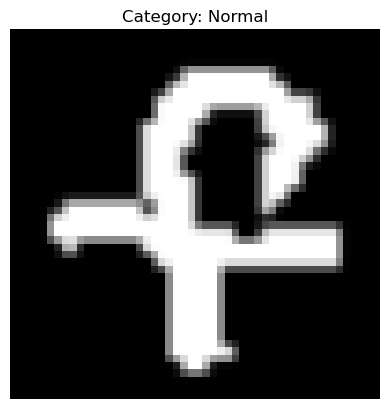

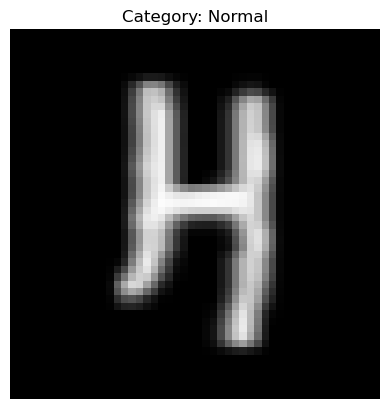

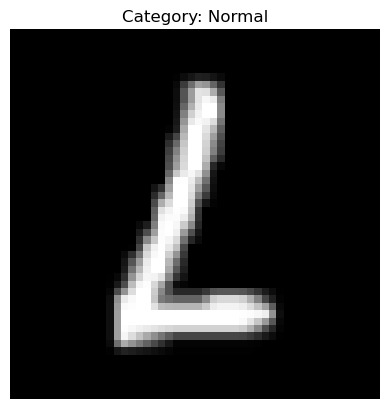

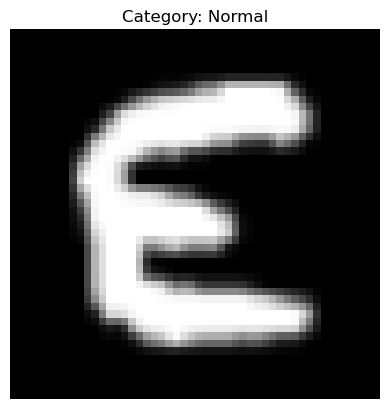

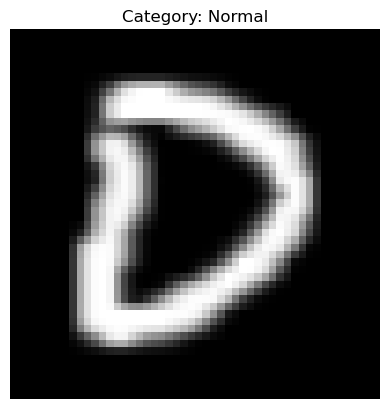

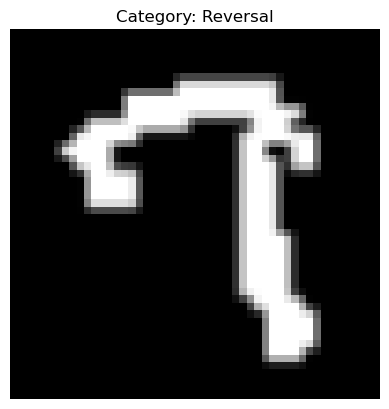

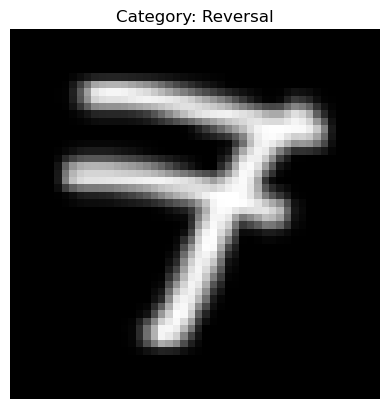

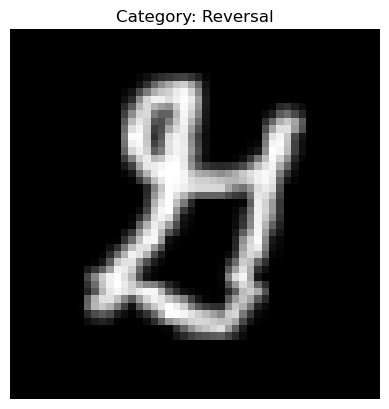

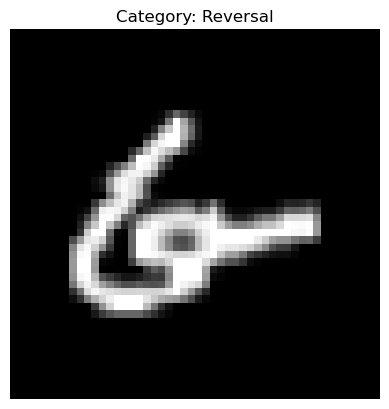

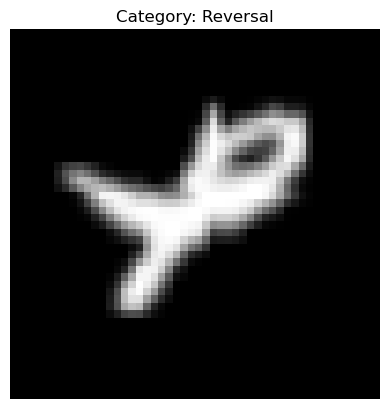

In [34]:
import os
import cv2
import random
import matplotlib.pyplot as plt

class HandwritingDataset:
    def __init__(self, data_path, output_size=(100, 100)):
        self.image_paths = []
        self.labels = []
        self.output_size = output_size
        self.label_mapping = {'Corrected': 1, 'Normal': 0, 'Reversal': 1}  # Mapping categories to labels
        self.load_data(data_path)

    def load_data(self, data_path):
        categories = ['Corrected', 'Normal', 'Reversal']
        for category in categories:
            category_path = os.path.join(data_path, category)
            if not os.path.exists(category_path):
                continue
            image_files = [file for file in os.listdir(category_path) if file.endswith('.png')]
            selected_files = random.sample(image_files, min(len(image_files), 5))  # Select at most 5 images
            for image_file in selected_files:
                self.image_paths.append(os.path.join(category_path, image_file))
                self.labels.append(self.label_mapping[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.output_size)
        return image, self.labels[idx]

    def display_images(self):
        num_images_to_display = 5
        for category in ['Corrected', 'Normal', 'Reversal']:
            category_paths = [path for path, label in zip(self.image_paths, self.labels) if self.label_mapping[category] == label]
            selected_paths = random.sample(category_paths, min(len(category_paths), num_images_to_display))
            for image_path in selected_paths:
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, self.output_size)

                plt.imshow(image)
                plt.title(f"Category: {category}")
                plt.axis('off')
                plt.show()
    
    def save_images(self, save_path):
        os.makedirs(save_path, exist_ok=True)
        for category in ['Corrected', 'Reversal']:
            category_paths = [path for path, label in zip(self.image_paths, self.labels) if self.label_mapping[category] == label]
            for idx, image_path in enumerate(category_paths):
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, self.output_size)

                # Save images based on category
                category_name = 'Dyslexic'
                filename = f"{category_name}_{idx+1}.png"
                save_file_path = os.path.join(save_path, filename)
                cv2.imwrite(save_file_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

            # Save 'Normal' images as 'Non-dyslexic'
            normal_category_paths = [path for path, label in zip(self.image_paths, self.labels) if self.label_mapping['Normal'] == label]
            for idx, image_path in enumerate(normal_category_paths):
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, self.output_size)

                category_name = 'Non-dyslexic'
                filename = f"{category_name}_{idx+1}.png"
                save_file_path = os.path.join(save_path, filename)
                cv2.imwrite(save_file_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Example usage:
data_path = 'E:/Gambo/Train'
handwriting_dataset = HandwritingDataset(data_path, output_size=(50, 50))  # Output size changed to (50, 50)

# Display selected images
handwriting_dataset.display_images()

# Save selected images based on dyslexic classification
save_folder = 'E:/SavedImages45'  # Define your save path here
handwriting_dataset.save_images(save_folder)


In [35]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

class HandwritingDataset(torch.utils.data.Dataset):
    def __init__(self, df, size):
        self.df = df
        self.size = size
        self.transforms = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        image = self.transforms(image)
        return image, label

def extract_features(df, model_name='densenet121', layer_name='features'):
    get_model = getattr(torchvision.models, model_name)
    model = get_model(pretrained=True)
    model.eval()

    features = []
    def hook(module, input, output):
        N, C, H, W = output.shape
        output = output.reshape(N, C, -1)
        features.append(output.mean(dim=2).detach().numpy())
    
    handle = model._modules.get(layer_name).register_forward_hook(hook)

    dataset = HandwritingDataset(df, size=224)
    loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)

    for inputs, labels in tqdm(loader, total=len(loader)):
        _ = model(inputs)

    features = np.concatenate(features)
    features_df = pd.DataFrame(features)
    features_df = features_df.add_prefix('FEATURE_')
    features_df['LABEL'] = df['label'].values
    
    handle.remove()
    del model

    return features_df


In [36]:
import os

# Define the main directories
train_path = 'E:/Gambo/Train'  # Replace with your actual path to the training data
test_path = 'E:/Gambo/Test'    # Replace with your actual path to the testing data

# List of subfolders
subfolders = ['Corrected', 'Normal', 'Reversal']

# Set permissions for train folders
for folder in subfolders:
    folder_path = os.path.join(train_path, folder)
    os.chmod(folder_path, 0o777)  # Change permissions as needed

# Set permissions for test folders
for folder in subfolders:
    folder_path = os.path.join(test_path, folder)
    os.chmod(folder_path, 0o777)  # Change permissions as needed


In [37]:
train_dir = 'E:/Gambo/train'
test_dir = 'E:/Gambo/test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=32,
    class_mode='categorical'
)
labels_dict = {class_name: label for label, class_name in train_generator.class_indices.items()}
print(labels_dict)

Found 151649 images belonging to 3 classes.
Found 56723 images belonging to 3 classes.
{0: 'Corrected', 1: 'Normal', 2: 'Reversal'}


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow.compat.v1 import disable_resource_variables



disable_resource_variables()

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
model.save('dyscnnmodel.keras')


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

In [39]:
import os
import shutil

# Source and destination directories
source_dir = 'E:/Gambo/Train'
destination_dir = 'E:/ProcessedData'

# Create destination directories
os.makedirs(os.path.join(destination_dir, 'Dyslexic'), exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'NonDyslexic'), exist_ok=True)

# Mapping classes to labels
class_mapping = {
    'Corrected': 'Dyslexic',
    'Reversal': 'Dyslexic',
    'Normal': 'NonDyslexic'
}

# Loop through the source directory
for class_folder in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_folder)
    if os.path.isdir(class_path):
        label = class_mapping[class_folder]
        destination_path = os.path.join(destination_dir, label)
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            if file.endswith('.png'):
                shutil.copy(file_path, destination_path)


In [40]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.n // test_generator.batch_size
)


Epoch 1/15



4739/4739 [==============================] - 421s 88ms/step - loss: 0.3638 - accuracy: 0.8601 - val_loss: 0.3760 - val_accuracy: 0.8601
Epoch 2/15
4739/4739 [==============================] - 150s 32ms/step - loss: 0.2192 - accuracy: 0.9203 - val_loss: 0.3454 - val_accuracy: 0.8803
Epoch 3/15
4739/4739 [==============================] - 147s 31ms/step - loss: 0.1823 - accuracy: 0.9339 - val_loss: 0.3399 - val_accuracy: 0.8826
Epoch 4/15
4739/4739 [==============================] - 167s 35ms/step - loss: 0.1616 - accuracy: 0.9421 - val_loss: 0.3162 - val_accuracy: 0.8889
Epoch 5/15
4739/4739 [==============================] - 171s 36ms/step - loss: 0.1495 - accuracy: 0.9458 - val_loss: 0.3487 - val_accuracy: 0.8911
Epoch 6/15
4739/4739 [==============================] - 156s 33ms/step - loss: 0.1433 - accuracy: 0.9490 - val_loss: 0.3502 - val_accuracy: 0.8922
Epoch 7/15
4739/4739 [==============================] - 186s 39ms/step - loss: 0.1366 - accuracy: 0.9513 - val_loss: 0.3495 - val

In [41]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1773/1773 [==============================] - 34s 19ms/step - loss: 0.3766 - accuracy: 0.8914
Test Loss: 0.37658658623695374
Test Accuracy: 0.8914020657539368


In [6]:
import fitz  # PyMuPDF
import re
import requests  # Import the requests library

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(doc.page_count):
        page = doc[page_num]
        text += page.get_text()
    doc.close()
    return text

# Function to extract words of a specific length from text
def extract_words_of_length(text, length):
    words = re.findall(r'\b\w+\b', text.lower())  # Extract words (ignoring punctuation)
    return [word for word in words if len(word) == length]

# URL of the PDF file
pdf_url = "https://downloads.allaboutlearningpress.com/downloads/Blog_Samples/The-Big-List-of-Homophones.pdf"

# Download the PDF file
pdf_filename = "homophones.pdf"
response = requests.get(pdf_url)
with open(pdf_filename, 'wb') as pdf_file:
    pdf_file.write(response.content)

# Extract text from the PDF
pdf_text = extract_text_from_pdf(pdf_filename)

# Extract 3, 4, and 5-letter words
three_letter_words = extract_words_of_length(pdf_text, 3)
four_letter_words = extract_words_of_length(pdf_text, 4)
five_letter_words = extract_words_of_length(pdf_text, 5)

# Combine the words
all_words = three_letter_words + four_letter_words + five_letter_words

# Save the words to a text file
output_file_path = "homophones.txt"
with open(output_file_path, 'w') as file:
    for word in all_words:
        file.write(word + '\n')

print(f"Scraped {len(all_words)} words. Saved to {output_file_path}")


Scraped 1882 words. Saved to homophones.txt


In [7]:
import random

# Load the list of words from the file
with open('homophones.txt', 'r') as file:
    word_list = file.read().splitlines()

# Randomly select 500 words
selected_words = random.sample(word_list, 500)

# Save the selected words to a new text file
with open('selected_homophones.txt', 'w') as file:
    for word in selected_words:
        file.write(word + '\n')

print("Randomly selected 500 words. Saved to selected_homophones.txt")


Randomly selected 500 words. Saved to selected_homophones.txt


In [8]:
import os
from gtts import gTTS
import random
from pydub import AudioSegment

# Read homophones from the text file
with open('selected_homophones.txt', 'r') as file:
    all_words = [line.strip() for line in file]

# Randomly select 5 words
selected_words = random.sample(all_words, 5)

selected_words_file = 'selected_words.txt'
with open(selected_words_file, 'w') as file:
    file.write("\n".join(selected_words))

# Create folders to save audio files
audio_folder = 'audio_outputs'
combined_audio_folder = 'combined_audio'
os.makedirs(audio_folder, exist_ok=True)
os.makedirs(combined_audio_folder, exist_ok=True)

def speak_word(word, spelling, index):
    # Speak the word
    text_to_speak_word = f"The word is {word}."
    tts_word = gTTS(text=text_to_speak_word, lang='en', slow=True) 
    #tts_word = gTTS(text=text_to_speak_word, lang='en')
    audio_path_word = os.path.join(audio_folder, f'audio_{index}_word.mp3')
    tts_word.save(audio_path_word)

    # Save the spelling audio separately
    spelling_tts = gTTS(text=spelling, lang='en', slow=True)
   # spelling_tts = gTTS(text=spelling, lang='en')
    spelling_audio_path = os.path.join(audio_folder, f'audio_{index}_spelling.mp3')
    spelling_tts.save(spelling_audio_path)

    # Load audio segments
    word_audio = AudioSegment.from_mp3(audio_path_word)
    spelling_audio = AudioSegment.from_mp3(spelling_audio_path)

    # Combine word and spelling audio into a single file
    combined_audio = word_audio + spelling_audio
    combined_path = os.path.join(combined_audio_folder, f'combined_{index}.mp3')
    combined_audio.export(combined_path, format='mp3')

    # Print the duration of the combined audio
    print(f"Duration of combined audio {index}: {len(combined_audio) / 1000} seconds")

# Iterate over each selected word and its spelling
for index, word in enumerate(selected_words, 1):
    # Assume the spelling is just the word itself, you can replace it with actual spellings
    spelling = " ".join(word)

    # Speak the word and its spelling
    speak_word(word, spelling, index)

print("All words spoken.")


Duration of combined audio 1: 4.128 seconds
Duration of combined audio 2: 3.36 seconds
Duration of combined audio 3: 3.816 seconds
Duration of combined audio 4: 3.936 seconds
Duration of combined audio 5: 3.36 seconds
All words spoken.


In [9]:
import tkinter as tk
from tkinter import messagebox
from PIL import Image, ImageDraw
import os
import pygame

# Initialize Tkinter
root = tk.Tk()
root.title("Word Writing App")

# Set up the canvas
canvas = tk.Canvas(root, width=400, height=400, bg="white")
canvas.pack()

# Set up the audio folder
combined_audio_folder = 'combined_audio'
audio_files = [file for file in os.listdir(combined_audio_folder) if file.endswith('.mp3')]
audio_files.sort()

# Set up the image saving folder
image_save_folder = 'drawn_images'
os.makedirs(image_save_folder, exist_ok=True)

# Set up the information saving file (simple text file for demonstration)
info_file_path = 'user_info.txt'

# Initialize pygame mixer
pygame.mixer.init()

# Function to play the combined audio
def play_combined_audio(index):
    audio_path = os.path.join(combined_audio_folder, audio_files[index])
    pygame.mixer.music.load(audio_path)
    pygame.mixer.music.play()

# Function to create a new drawing canvas for each word
def create_new_canvas():
    image = Image.new("RGB", (400, 400), "white")
    draw = ImageDraw.Draw(image)
    return image, draw

# Function to clear the canvas
def clear_canvas():
    canvas.delete("all")

# Function to display a new word
def display_word(index):
    global image, draw
    clear_canvas()
    image, draw = create_new_canvas()
    play_combined_audio(index)
    label_word.config(text=f"Write the word!")
    root.after(5000, lambda: save_image(index))  # Increase the delay to 5000 milliseconds (5 seconds)

# Function to save the drawn image along with user information
def save_image(index):
    canvas.unbind("<B1-Motion>")  # Disable drawing during the delay
    filename = os.path.join(image_save_folder, f"word_{index}_drawing.png")
    image.save(filename)

    # Collect user information
    name = entry_name.get()
    age = entry_age.get()

    # Save user information along with the filename
    with open(info_file_path, 'a') as info_file:
        info_file.write(f"Name: {name}, Age: {age}, Image: {filename}\n")

    messagebox.showinfo("Saved", f"Image saved as {filename}")
    clear_canvas()  # Clear the canvas before allowing the next word
    canvas.bind("<B1-Motion>", paint)  # Enable drawing for the next word
    if index < len(audio_files) - 1:
        display_word(index + 1)
    else:
        label_word.config(text="All words completed!")

# Entry for user to input name
label_name = tk.Label(root, text="Name:")
label_name.pack()
entry_name = tk.Entry(root)
entry_name.pack()

# Entry for user to input age
label_age = tk.Label(root, text="Age:")
label_age.pack()
entry_age = tk.Entry(root)
entry_age.pack()

# Button to save the current drawing
button_save = tk.Button(root, text="Save", command=lambda: save_image(current_word_index))
button_save.pack()

# Label to display instructions
label_word = tk.Label(root, text="")
label_word.pack()

# Binding for drawing on the canvas
def paint(event):
    x1, y1 = (event.x - 5), (event.y - 5)
    x2, y2 = (event.x + 5), (event.y + 5)
    canvas.create_oval(x1, y1, x2, y2, fill="black")  # Draw in black color
    draw.line([x1, y1, x2, y2], fill="black", width=10)  # Draw in black color

canvas.bind("<B1-Motion>", paint)

# Display the first word
current_word_index = 0
image, draw = create_new_canvas()
display_word(current_word_index)

# Start the event loop
root.mainloop()


pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [10]:
import cv2
import os
import pytesseract
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model_path = 'dyscnnmodel.keras'  # Replace with your model path
model = load_model(model_path)

# Function to perform OCR on a given image
def perform_ocr(image_path):
    # Read the image and perform OCR
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from left to right
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])

    # Predict each letter
    predicted_letters = []
    for contour in contours:
        # Get bounding box coordinates for each contour
        x, y, w, h = cv2.boundingRect(contour)

        # Extract the letter region from the image
        letter = gray[y:y + h, x:x + w]

        # Resize the letter region to match the model's input shape
        resized_letter = cv2.resize(letter, (28, 28))

        # Convert letter to RGB format (3 channels)
        resized_letter_rgb = cv2.cvtColor(resized_letter, cv2.COLOR_GRAY2RGB)

        # Prepare the letter image for prediction
        letter_for_prediction = np.expand_dims(resized_letter_rgb, axis=0)
        letter_for_prediction = letter_for_prediction / 255.0  # Normalize pixel values

        # Predict using the loaded model
        prediction = np.argmax(model.predict(letter_for_prediction), axis=-1)
        predicted_letters.append(chr(prediction.item() + 97))  # Convert prediction to letter (assuming class indices 0-25)

    return predicted_letters

# Function to check dyslexia based on OCR output
def check_dyslexia(ocr_output, selected_words):
    dyslexic_words = set(ocr_output) - set(selected_words)
    return len(dyslexic_words) > 0

# Folder containing drawn images
image_folder = 'drawn_images'

# Tesseract OCR configuration
config_ocr = ('-l eng --oem 1 --psm 3')

# Set Tesseract executable path (replace with your path)
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

# Read selected words from a text file
selected_words_file = 'selected_words.txt'
with open(selected_words_file, 'r') as file:
    selected_words = set([word.strip() for word in file.readlines()])

# Iterate over images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith('.png'):
        image_path = os.path.join(image_folder, filename)

        # Perform OCR on the image
        ext = pytesseract.image_to_string(cv2.imread(image_path), config=config_ocr)
        text_ocr = ext.split('\n')  # Splitting the OCR output into lines
        print("OCR Text:", text_ocr)

        predicted_letters = perform_ocr(image_path)

        # Check dyslexia based on OCR output
        is_dyslexic = check_dyslexia(predicted_letters, selected_words)

        # Print classification result for the current image
        if is_dyslexic:
            print(f"Image: {filename}, Classification: Dyslexic")
        else:
            print(f"Image: {filename}, Classification: Non-Dyslexic")


OCR Text: ['(ian', '']
1/1 [==============================] - 0s 26ms/step
Image: word_0_drawing.png, Classification: Dyslexic
OCR Text: ['Qo', '']
1/1 [==============================] - 0s 28ms/step
Image: word_1_drawing.png, Classification: Dyslexic
OCR Text: ['']
1/1 [==============================] - 0s 29ms/step
Image: word_2_drawing.png, Classification: Dyslexic
OCR Text: ['']
1/1 [==============================] - 0s 25ms/step
Image: word_3_drawing.png, Classification: Dyslexic
OCR Text: ['']
1/1 [==============================] - 0s 26ms/step
Image: word_4_drawing.png, Classification: Dyslexic
